## Download Data

In [139]:
import os
import tarfile
import urllib

"""
Downloading a CSV tarball to use for model
"""

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path) # temporarily stores tarball at tgz_path
    housing_file = tarfile.open(tgz_path)
    housing_file.extractall(path=housing_path)
    housing_file.close()
    
fetch_housing_data()

## Load in Data Structure

In [140]:
import pandas as pd

"""
Return pandas DF with housing data
"""

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing_data = load_housing_data()
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Visualize Data

In [141]:
housing_data.info()
housing_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


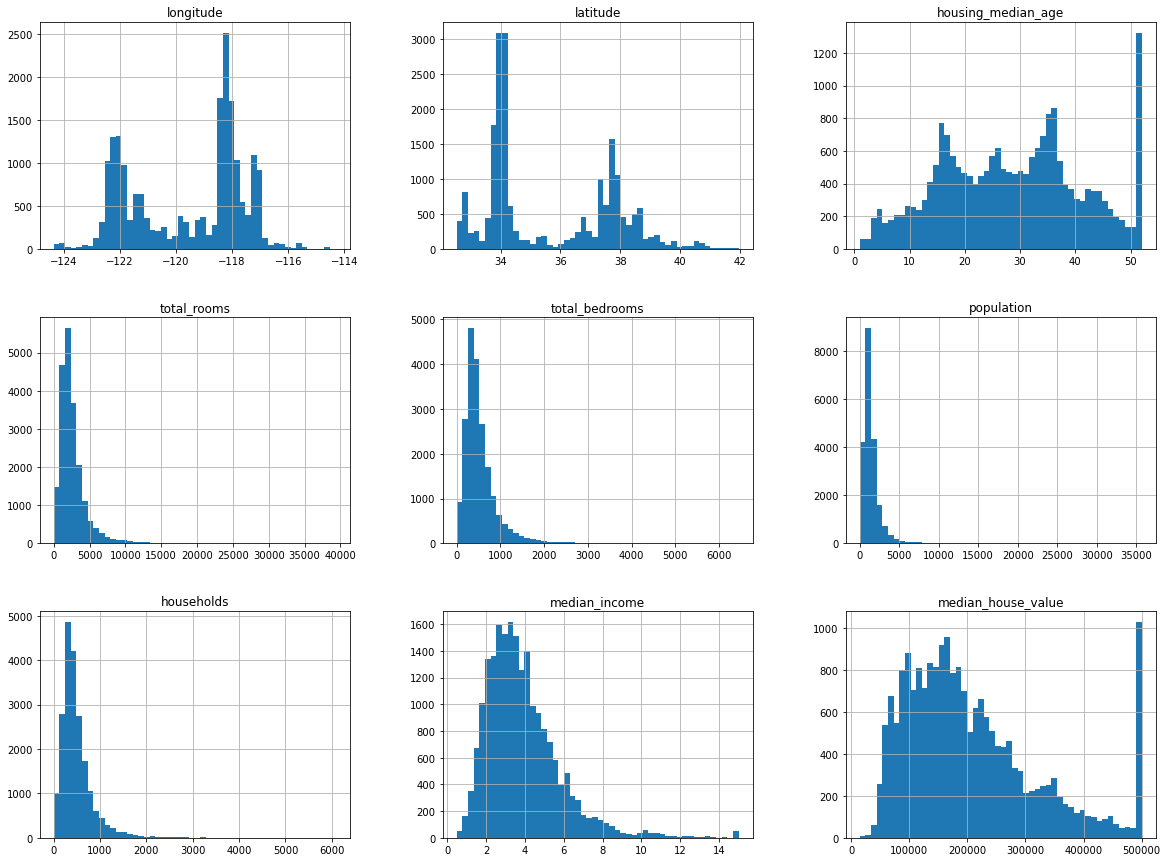

In [142]:
# Need to specify graphical backend for matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

"""
Visualize data in order to figure out what 
"""

housing_data.hist(bins=50, figsize=(20, 15))
plt.show()

Income is a very important attribute for this model. We need to examine this more closely and see the distribution of districts in different income categories

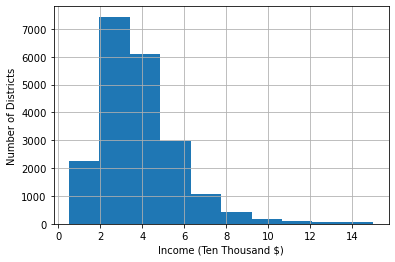

In [143]:
housing_data["median_income"].hist(bins=10)
plt.xlabel("Income (Ten Thousand $)")
plt.ylabel("Number of Districts")
plt.show()

The tail end of the income distribution may leave too few data points for meaningful use. We should condense our bins so each strata has enough data

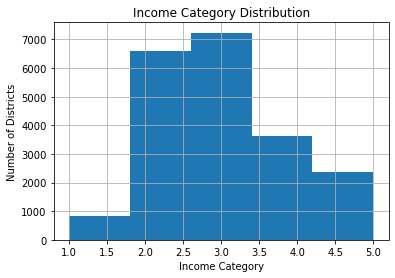

In [144]:
import numpy as np
# Each Category Represents $15,000 in income. Cat1 = $0 - 15,000, Cat2 = $15,000 - 30,000, etc.
# Cat5 is $60,000 and up, since there are not a ton of data points past that

housing_data["income_category"] = pd.cut(housing_data["median_income"], 
                                         bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf],
                                         labels=[1, 2, 3, 4, 5])

housing_data["income_category"].hist(bins=5)
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")
plt.title("Income Category Distribution")
plt.show()

Now that we know the distribution of incomes, we want to take a stratified random sample using this distribution to use as our testing data.

## Stratified Testing Data Split

In [145]:
from sklearn.model_selection import StratifiedShuffleSplit

"""
Link: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html 

We only need to iterate once, n=1
Use 20% of data for test split, test_size=0.2
Select a random state so our split is the same through different runs, rnadom_state=7

.split(data, target_variable) will return the ndarray of indices to use for each set
We will use housing_data["income_category"] to stratify the testing data
"""

test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)

for train_idx, test_idx in test_split.split(housing_data, housing_data["income_category"]):
    stratified_training_set = housing_data.loc[train_idx]
    stratified_test_set = housing_data.loc[test_idx]

# Check that the split work with our desired distribution
print ("Test Set")
print(stratified_test_set["income_category"].value_counts() / len(stratified_test_set))

print ("\nTraining Set")
print(stratified_training_set["income_category"].value_counts() / len(stratified_training_set))

# Remove the Income Category column, since it will not actually be used for our training
# Axis = 0 is for rows, Axis = 1 is for columns
for ssets in (stratified_test_set, stratified_training_set):
    ssets.drop("income_category", axis=1, inplace=True)

# Check that everything is good
stratified_test_set.head()

Test Set
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_category, dtype: float64

Training Set
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_category, dtype: float64


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
19752,-122.22,40.18,13.0,3719.0,803.0,1754.0,764.0,2.3517,88900.0,INLAND
17692,-121.81,37.29,15.0,5957.0,1037.0,3838.0,997.0,6.2907,253100.0,<1H OCEAN
1689,-122.26,38.02,5.0,3846.0,786.0,2053.0,716.0,5.0473,184800.0,NEAR BAY
8369,-118.34,33.98,47.0,2649.0,684.0,2374.0,607.0,2.3882,137700.0,<1H OCEAN
17245,-119.67,34.42,37.0,1673.0,444.0,1477.0,446.0,2.0643,246700.0,<1H OCEAN


## Explore Data 

Copy stratified training data so we can play around with it. Reminder: leave the test set alone and do not look at it!

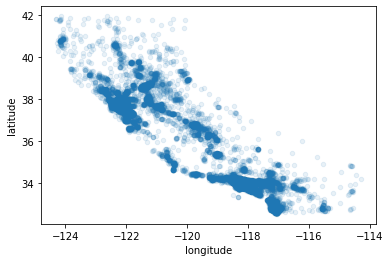

In [148]:
# LOCATION
'''
Visualize geographical location of districts using coordinates
alpha controls the opacity of each data point, which will allow us to visualize density
'''
explore_set = stratified_training_set.copy()
explore_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

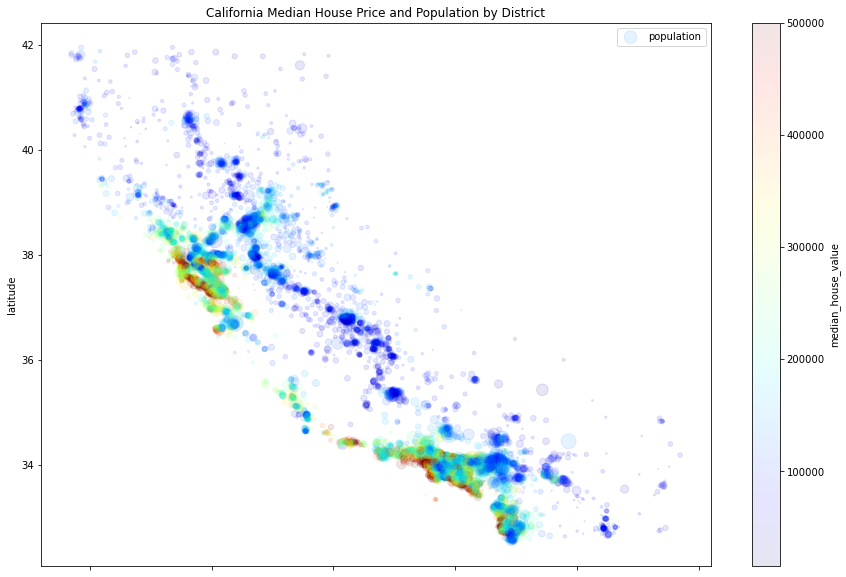

In [150]:
# PRICES AND LOCATIONS
"""
Visualize the median price of a house in each district using
coordinates and mediam house value

s = size of circle = population
c = input to colormap = median house price, use jet (predefined color map)
colorbar=True will print a legend for the colors
"""
explore_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, 
                s=explore_set["population"]/50, label="population", figsize=(15, 10),
                c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.xlabel("longitude")
plt.title("California Median House Price and Population by District")
plt.legend()
plt.show()

Since the dataset isn't too large, we can computethe correlation coefficient for each pair of data types. Remember that this won't characterize any non-linear relationships that exist, but it can still give us some insights. 

In [151]:
correlations = explore_set.corr()
print("Correlations with Housing Value:\n", correlations["median_house_value"].sort_values(ascending=False))
print("\nCorrelations with Population:\n", correlations["population"].sort_values(ascending=False))
print("\nCorrelations with Median Income:\n", correlations["median_income"].sort_values(ascending=False))

Correlations with Housing Value:
 median_house_value    1.000000
median_income         0.686289
total_rooms           0.135723
housing_median_age    0.109030
households            0.066404
total_bedrooms        0.050819
population           -0.024405
longitude            -0.045513
latitude             -0.145896
Name: median_house_value, dtype: float64

Correlations with Population:
 population            1.000000
households            0.912986
total_bedrooms        0.882767
total_rooms           0.861349
longitude             0.102938
median_income         0.005594
median_house_value   -0.024405
latitude             -0.112527
housing_median_age   -0.302209
Name: population, dtype: float64

Correlations with Median Income:
 median_income         1.000000
median_house_value    0.686289
total_rooms           0.199076
households            0.011561
population            0.005594
total_bedrooms       -0.008819
longitude            -0.013145
latitude             -0.081630
housing_median_age 

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='population', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>,
        <AxesSubplot:xlabel='population', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel

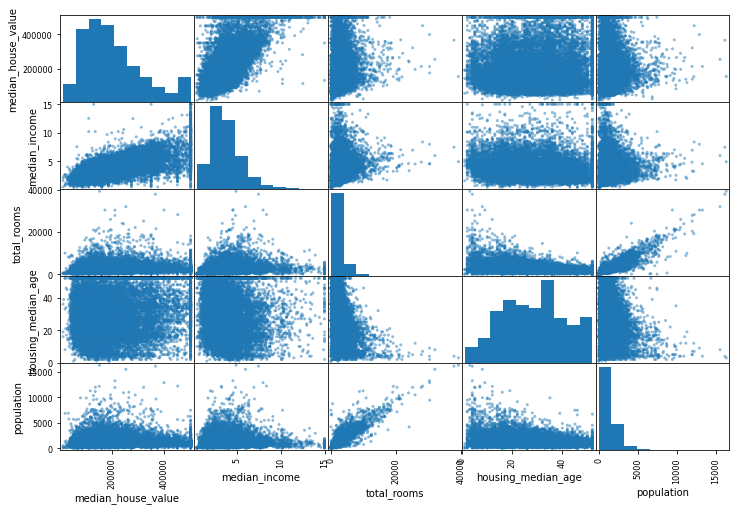

In [154]:
from pandas.plotting import scatter_matrix

'''
Scatter matrix plots all attributes against all other attributes
Pick the most important attributes to look for relationships
'''

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age", "population"]

scatter_matrix(explore_set[attributes], figsize=(12,8))

Possible Correlations:
- Median House Value and Median Income (Strong)
- Population and Total Rooms (Strong)
- Total Rooms and Median Income

We care most about the median house value, so median income is a value of interest

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

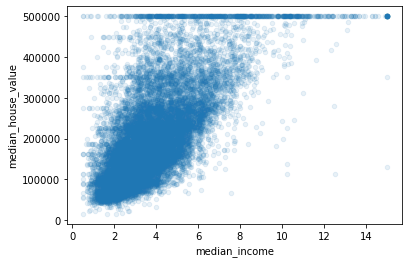

In [156]:
explore_set.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

We should calculate more useful traits from existing ones. 

In [210]:
explore_set["rooms_per_house"] = explore_set["total_rooms"] / explore_set["households"]
explore_set["bedrooms_per_room"] = explore_set["total_bedrooms"] / explore_set["total_rooms"]
explore_set["population_per_household"] = explore_set["population"] / explore_set["households"]

explore_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,bedrooms_per_room,population_per_household
8088,-118.21,33.82,34.0,1719.0,398.0,1444.0,372.0,2.8438,139300.0,NEAR OCEAN,4.620968,0.231530,3.881720
15259,-117.27,33.03,25.0,1787.0,311.0,1108.0,311.0,3.9826,215800.0,NEAR OCEAN,5.745981,0.174035,3.562701
710,-122.08,37.68,26.0,1167.0,370.0,253.0,137.0,2.4196,275000.0,NEAR BAY,8.518248,0.317052,1.846715
12828,-121.45,38.70,24.0,2159.0,369.0,1141.0,355.0,3.9853,90400.0,INLAND,6.081690,0.170912,3.214085
18294,-122.10,37.39,35.0,2471.0,349.0,881.0,342.0,7.6229,500001.0,NEAR BAY,7.225146,0.141238,2.576023


In [212]:
explore_correlations = explore_set.corr()
explore_correlations["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.686289
rooms_per_house             0.147401
total_rooms                 0.135723
housing_median_age          0.109030
households                  0.066404
total_bedrooms              0.050819
population_per_household   -0.021876
population                 -0.024405
longitude                  -0.045513
latitude                   -0.145896
bedrooms_per_room          -0.253819
Name: median_house_value, dtype: float64

In [213]:
# Note: .drop() will return a copy without the column if inline=False
# Drop the median housing price from our data set and create a label set with it
housing_data = stratified_training_set.drop("median_house_value", axis=1)
housing_data_labels = stratified_training_set["median_house_value"].copy()

## Data Cleaning 

Scikit-learn Notes:

Estimators:
- Any object that estimates a paramter based on the given dataset (eg. imputer)
- Estimation is done with the fit() method --> one dataset for unsupervised, two (data + labels) for supervised
- Any other variable is considered a hyperparameter and is set as an instance variable via constructer (eg. strategy="median)

Transformers:
- Done with the transform() method, dataset being transformed is the parameter
- Relies on learned parameters
- ** the function fit_transform() first fits to then transforms the passed in dataset 

Predictors:
- Estimators that are capable of making predictions from a dataset (eg. LinearRegression)
- predict() method takes in a dataset of new instances and returns dataset of corresponding predictions
- score() method measures the quality of predictions given a test set (and labels in supervised learning)

Inspection:
- Estimator's hyperparameters (eg. imputer.strategy) are accesible as public instance variables
- Estimator's learned parameters (eg. imputer.statistics_) are accesible as public instance variables with a _ suffix

Nonproliferation of Class:
- Datasets are either numpy arrays or scipy sparse matrices
- Hyperparameters are regular Python strings or numbers 

In [ ]:
# Note: single brackets [] to select a column will result in a pandas.Series
# double brackets [[]] to select a column will result in a pandas.DataFrame
housing_data[["ocean_proximity"]].head(10)

In [215]:
"""
We have a few options when getting rid of missing/null values in our data set:
1. Remove corresponding instances
2. Remove the entire attribute
3. Set the values to other usable values (eg. 0, the mean, the median, etc.)

We will use scikit-learn's SimpleImpute function to replace missing values with the median 
Note: this only works with numeric values

We will fit the imputer to all housing numeric values, it will be stored in the statistics_ variable
"""
"""
To convert qualitative features like ocean proximity to numeric values, we can use sklearn.preprocessing's OneHotEncoder
This will use 1 to representent True for whether or not an instance had that trait
Eg. if <1 OCEAN, then that instance will have a 1 in that column and a 0 in all other columns
This is useful so that the categories are considered as features without comparing between categories
Fit Transform with a OneHotEncoder will return a scipy sparse matrix, which is useful when most values are empty
"""

from sklearn.preprocessing import OneHotEncoder

category_encoder = OneHotEncoder()
housing_category = housing_data[["ocean_proximity"]]
housing_category_encoded = category_encoder.fit_transform(housing_category) # will return a sparse matrix
category_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Duck typing is a type pf typing used in dynamic programming languages, where the methods/attributes defined by an object are more important than the type/class.

## Custom Transformer

In [234]:
"""
We can define a custom transform to add important attributes to our data
Current Columns:
longitude, latitude, housing_median_age, total_rooms, total_bedrooms, 
population, households, median_income, median_house_value, ocean_proximity
"""

# explore_set_values = explore_set.values
# new_set = explore_set_values[:, 3] / explore_set_values[:, 6]
# print(new_set)

from sklearn.base import BaseEstimator, TransformerMixin

total_rooms_idx, total_bedrooms_idx, pop_idx, num_houses_idx = 3, 4, 5, 6

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self # do not need to fit to anything 
    
    def transform(self, X):
        rooms_per_household = X[:, total_rooms_idx] / X[:, num_houses_idx]
        population_per_household = X[:, pop_idx] / X[:, num_houses_idx]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, total_bedrooms_idx] / X[:, total_rooms_idx]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

training_set_copy = stratified_training_set.copy()
attr_adder = CombinedAttributeAdder()
explore_added_attr = attr_adder.transform(training_set_copy.values)
added_attr_set = pd.DataFrame(explore_added_attr, 
                              columns=["longitude", "latitude", "housing_median_age", "total_rooms", 
                                        "total_bedrooms", "population", "households", 
                                        "median_income", "median_house_value", "ocean_proximity", 
                                        "rooms_per_house", "population_per_household", "bedrooms_per_room"], 
                              index=explore_set.index)
added_attr_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,population_per_household,bedrooms_per_room
8088,-118.21,33.82,34.0,1719.0,398.0,1444.0,372.0,2.8438,139300.0,NEAR OCEAN,4.620968,3.88172,0.23153
15259,-117.27,33.03,25.0,1787.0,311.0,1108.0,311.0,3.9826,215800.0,NEAR OCEAN,5.745981,3.562701,0.174035
710,-122.08,37.68,26.0,1167.0,370.0,253.0,137.0,2.4196,275000.0,NEAR BAY,8.518248,1.846715,0.317052
12828,-121.45,38.7,24.0,2159.0,369.0,1141.0,355.0,3.9853,90400.0,INLAND,6.08169,3.214085,0.170912
18294,-122.1,37.39,35.0,2471.0,349.0,881.0,342.0,7.6229,500001.0,NEAR BAY,7.225146,2.576023,0.141238
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8285,-118.14,33.77,51.0,2812.0,621.0,1171.0,566.0,3.875,342900.0,NEAR OCEAN,4.968198,2.068905,0.220839
20569,-121.76,38.66,17.0,5320.0,984.0,2866.0,928.0,4.1997,133400.0,INLAND,5.732759,3.088362,0.184962
12632,-121.48,38.49,26.0,3165.0,806.0,2447.0,752.0,1.5908,78600.0,INLAND,4.208777,3.253989,0.25466
5135,-118.26,33.97,46.0,1521.0,352.0,1100.0,334.0,1.55,100600.0,<1H OCEAN,4.553892,3.293413,0.231427


## Transformation Pipeline

In [245]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attr_added', CombinedAttributeAdder()),
    ('std_scaler', StandardScaler())
])

# Need to pass in list of column names to be transformed
# OneHotEncoder() will return a spare matrix if density of the whole set is < 0.3
housing_num = stratified_training_set.drop("ocean_proximity", axis=1)
housing_num = housing_num.drop("median_house_value", axis=1)
num_columns = list(housing_num)
cat_columns = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("numerical_transform", numerical_pipeline, num_columns), 
    ("categorical_transform", OneHotEncoder(), cat_columns)
])


housing_data_prepared = full_pipeline.fit_transform(added_attr_set)
housing_data_prepared

array([[ 0.68138959, -0.85169496,  0.42209878, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.15127891, -1.22193521, -0.29452206, ...,  0.        ,
         0.        ,  1.        ],
       [-1.25315474,  0.95732705, -0.21489752, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.95322539,  1.33694048, -0.21489752, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.65639548, -0.78139617,  1.37759324, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.56141785,  0.75580388, -0.69264475, ...,  0.        ,
         0.        ,  0.        ]])

## Select & Train Model

Process so far:
- Frame the problem
- Download and explore/visualize data
- Sampled training and test sets
- Added important attributes and tested relationships
- Transformed data (clean and prepare) for ML Algorithm

We will now experiment and test a linear regression model as a baseline

In [249]:
from sklearn.linear_model import LinearRegression

lin_regress = LinearRegression()
lin_regress.fit(housing_data_prepared, housing_data_labels)

# Test out this model
training_set_no_labels = stratified_training_set.drop("median_house_value", axis=1)
some_data = training_set_no_labels.iloc[2:7]
some_labels = housing_data_labels.iloc[2:7]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_regress.predict(some_data_prepared))
print("\nActual: ", list(some_labels))

Predictions:  [196623.32365586 138853.09341481 386884.20734771 146494.12068469
 238571.66066559]

Actual:  [275000.0, 90400.0, 500001.0, 181800.0, 240700.0]


In [253]:
# Measure error on training set
from sklearn.metrics import mean_squared_error

housing_predictions = lin_regress.predict(housing_data_prepared)
linear_rmse = np.sqrt(mean_squared_error(housing_data_labels, housing_predictions))
print("RMSE: $", linear_rmse)

RMSE: $ 68026.71380807208


Since the RMSE value is so high, we can assume our model is underfitting. This can be because:
- The features given do not provide enough information to make predictions
- The constraints on the model are too strong (regularization, does not apply here)
- We are not using a powerful enough model